<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 最近鄰分類法(Nearest neighbors)
* 要有某種距離的概念
* 有個假設：距離較近的點彼此間會較類似

## 計算票數的函式

In [ ]:
# 
from typing import List
from collections import Counter

def raw_majority_vote(labels:List[str])->str:
  votes = Counter(labels)
  winner,_ = votes.most_common(1)[0]
  return winner

## 降低k值，直到找到唯一的結果為止。


In [ ]:
def majority_vote(labels:List[str])->str:
  """假設labels中的資料已事先依據從進到遠的順序排序"""
  vote_conuts = Counter(labels)
  winner,winner_count = vote_conuts.most_common(1)[0]
  num_winners = len([count for count in vote_conuts.values() if count == winner_count])
  
  if num_winners == 1:
    return winner
  else:
    return major_votes(labels[:-1])

引用第四章 線性代數 的函數

In [1]:
import math
from typing import List

Vector = List[float]

def subtrate( v:Vector, w:Vector) -> Vector:
  assert len(v) == len(w) #兩個向量必須有相同的維度

  return [ v_i-w_i for v_i,w_i in zip(v,w)]

def magnitude(v:Vector)->float:
  return math.sqrt(sum_of_squares(v)) #math.sqrt 是計算平方根的一個函式

def distance(v:Vector,w:Vector) -> float:
  return magnitude(subtrate(v,w))

def sum_of_squares(v:Vector) -> float:
  return dot(v,v)

def dot(v:Vector,w:Vector)->float:
  #計算v_1*w_1+... +v_n*w_n
  assert len(v)==len(w),"兩個向量必須有相同的維度"

  return sum(v_i*w_i for v_i,w_i in zip(v,w))

In [ ]:
from typing import NamedTuple

class LabeledPoint(NamedTuple):
  point:Vector
  label:str

def knn_classify(k:int,
         label_points:List[LabeledPoint],
         new_point:Vector) ->str:
  
  #針對這些已標示分類標籤的點，根據距離進到遠的順序進行排序
  by_distance = sorted(label_points,
             key=lambda lp:distance(lp.point,new_point))
  
  #找出k個最近點所對應的分類標籤
  k_nearest_labels = [lp.label for lp in by_distance[:k]]

  #讓他們進行投票
  return majority_vote(k_nearest_labels)

## 範例：鳶尾花資料集 
在機器學習方面常被運用的資料集。  
這個資料集包含150朵鳶尾花的測量值，每一朵花都有對應的花瓣長度、花瓣寬度、萼片長度與萼片寬度、以及它所屬品種。


**下載資料集**  
書本上採行Python內建的IO函式庫，在本地端進行資料讀寫。  
於CodeLab上實行，會發生讀寫錯誤只會建檔不會寫入資料。  
因而改為透過Numpy函式庫對資料進行處理。

In [ ]:
import csv
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

data=pd.read_csv(url, sep=',',header=None)

|sepal_length|sepal_width|petal_length|petal_width|class|  
|---|---|---|---|---|
|花瓣長度|花辦寬度|萼片長度|萼片寬度|品種
  
資料標籤(label)如上顯示↑

In [ ]:
# 進行預處理，將資料轉換為150個獨立陣列集合
preprocess_data = [list(data) for data in zip(list(data[0]),list(data[1]),list(data[2]),list(data[3]),list(data[4]))]

先將資料載入並轉為「LabeledPoint」物件作為輸入。

In [ ]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row:List[str])->LabeledPoint:
  """
  sepal_length, sepal_width, petal length, petal_width, class
  (花瓣長度,花辦寬度,等片長度,對片寬度,品種)
  """
  measurements = [float(value) for value in row[:-1]]
  
  #像"Iris-virginica"這樣的品種名稱，我們只取其中的"virginica"
  label = row[-1].split("-")[1]

  return LabeledPoint(measurements,label)

reader = data
iris_data = [parse_iris_row(row) for row in preprocess_data]

#我們只處理標有品種名稱的資料點，這樣才能順利畫出圖形
points_by_species:Dict[str,List[Vector]] = defaultdict(list)
for iris in iris_data:
  points_by_species[iris.label].append(iris.point)

### 圖 12-1 鳶尾花散點圖
由於資料有四個維度，很難直接繪製成圖形。  
透過將四種測量值兩兩配對形成六種配對方式，再觀察這六種組合的散點圖。

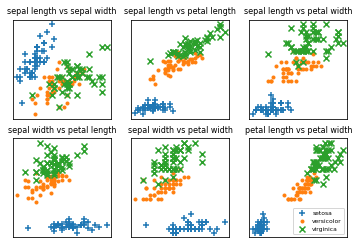

In [ ]:
from matplotlib import pyplot as plt 
metrics = ['sepal length','sepal width','petal length','petal width']
pairs=[(i,j) for i in range(4) for j in range(4) if i<j]
marks = ["+",".","x"] #資料共有三種類別，故採用三種不同的標記符號

fig,ax = plt.subplots(2,3) #建立2x3的子圖展示框架

for row in range(2):
  for col in range(3):
    i,j = pairs[3*row+col]
    ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}",fontsize=8)
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])

    for mark,(species,points) in zip(marks,points_by_species.items()):
      xs = [point[i] for point in points]
      ys = [point[j] for point in points]
      ax[row][col].scatter(xs,ys,marker=mark,label=species)

ax[-1][-1].legend(loc='lower right',prop={'size':6})
plt.show()

透過觀察圖形，可以觀察到測量值會隨著不同品種而構成不同的集群。

## 運用「k最近鄰」建立預測模型


首先，將資料拆分為測試組資料與訓練組資料

In [ ]:
import random
from typing import TypeVar,List,Tuple
X=TypeVar('X') #以通用型別來代表資料點

def split_data(data:List[X],prob:float) ->Tuple[List[X],List[X]]:
  """把資料依照[prob,1-prob]的比率進行切割"""
  data = data[:]        #複製一份資料
  random.shuffle(data)      #因shuffle會打亂資料
  cut = int(len(data)*prob)   #用prob算出切分點
  return data[:cut],data[cut:]  #用打亂過的資料進行切分

In [ ]:
random.seed(12)
iris_train,iris_test = split_data(iris_data,0.7)
assert len(iris_train)==0.7*150
assert len(iris_test)==0.3*150

In [ ]:
from typing import Tuple
import math

#追蹤紀錄我們看到幾次(預測值、實際值)
confusion_matrix:Dict[Tuple[str,str],int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
  predicted = knn_classify(5,iris_train,iris.point)
  actual= iris.label

  if predicted == actual:
    num_correct += 1

  confusion_matrix[(predicted,actual)] += 1

pct_correct = num_correct/len(iris_test)
print(pct_correct,confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


**針對這個簡單的資料集**：  
模型可以做出幾乎完美的預測。  
模型只有一次把**變色鳶尾(versicolor)**預測成**維吉尼亞鳶尾(virginica)**，但其他預測結果則完全正確。

# 維度的詛咒
在高維度空間中，每個點彼此之間的遠近關係，差異會變得不明顯。  
***隨著維度的增加，點與點之間的平均距離也會增加。***

建立一堆隨機資料點

In [2]:
from typing import List
import random
Vector = List[float]

def random_point(dim:int)->Vector:
  return [random.random() for _ in range(dim)]

計算相應的距離

In [3]:
from typing import List

def random_distances(dim:int,num_pairs:int) -> List[float]:
  return [distance(random_point(dim),random_point(dim)) for _ in range(num_pairs)]

針對1到100維的每個維度，各計算出10000個距離並用來檢查：
* 每個維度中，點與點之間的平均距離
* 每個維度中，與點之間的最小距離

In [9]:
import tqdm
dimensions = range(1,101)

avg_distance = []
min_distance = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
  distances = random_distances(dim,10000)
  avg_distance.append(sum(distances)/10000)
  min_distance.append(min(distances))

len(avg_distance)

Curse of Dimensionality: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


100

### 圖 12-2 維度的詛咒

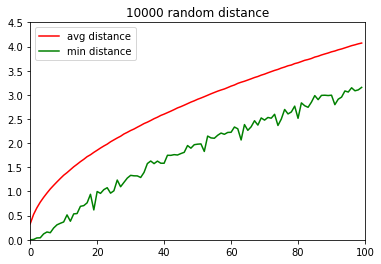

In [17]:
from matplotlib import pyplot as plt

xs=[num for num in range(100)]

plt.plot(xs,avg_distance,"r-",label="avg distance") #平均距離
plt.plot(xs,min_distance,"g-",label="min distance") #最小距離
plt.legend(loc=2)
plt.axis([0,100,0,4.5])
plt.title("10000 random distance")
plt.show()

***隨著維度的增加，點與點之間的平均距離也會增加。***

In [13]:
min_avg_ratio = [min_dist/avg_dist for min_dist,avg_dist in zip(min_distance,avg_distance)]

### 圖 12-3 又是一個維度的詛咒

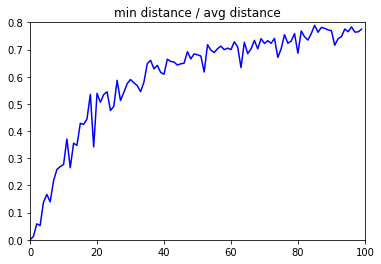

In [18]:
from matplotlib import pyplot as plt

xs=[num for num in range(100)]

plt.plot(xs,min_avg_ratio,"b-")
plt.title("min distance / avg distance")
plt.axis([0,100,0,0.8])
plt.show()

# 觀察高維度的稀疏性(sparsity)

### 圖12-4 50個一維的隨機點

In [ ]:
random_distances(1,50)

In [ ]:
from matplotlib import pyplot as plt

xs=random_distances(1,50)
ys=[1]*50
ys

#plt.bar(xs,ys,"k-") #平均距離
#plt.show()